# **Classification Project**
- Akshay Bankar (2019201011)
- Gajanan Modi (2019201049)

## **Problem Statement:**  To classify earthquake based on its magnitude (Mw)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score, classification_report
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
import datetime as dt
import seaborn as sns

In [2]:
filepath = "./Indian_Earthquakes_List Update_Magnitudes.csv"
df = pd.read_csv(filepath)
df.head()

,Sl. No.,YEAR,MONTH,DATE,ORIGIN TIME(UTC),Mw,Mb,Ms,ML,LAT (N),LONG (E),DEPTH (km),REFERENCE
0,1,-2474,0,0.0,NaN,7.5,6.969202899,7.260619977,7.427072403,71,24,0.0,Dr STGR
1,2,-325,0,0.0,NaN,7.5,6.969202899,7.260619977,7.427072403,71,24,0.0,Dr STGR
2,3,25,0,0.0,NaN,7.5,6.969202899,7.260619977,7.427072403,72.9,33.72,0.0,Dr STGR
3,4,26,5,10.0,08.19.10.0,6.1397,5.737047101,5.698851894,5.999685205,17.3,80.1,NaN,NEIC
4,5,26,5,10.0,08.19.10.0,6.1397,5.737047101,6.075520196,5.999685205,26,97,80.0,G-R


## Data Description:
As can be seen from the above snippet, the data contains,
- Time of earthquake defined by YEAR, MONTH, DATE and ORIGIN TIME(UTC)
- Earthquale magnitude scales defined by Moment magnitude(Mw),  body wave magnitude (Mb) and surface wave magnitude (Ms) and Local magnitude scale (ML).
- Origin of earthquale defined by latitude (LAT), longitude (LONG) and depth (DEPTH).
- References - These give the data source of each data point

## Data Cleaning:

In [3]:
df.isnull().sum()

Sl. No.                 0
YEAR                    0
MONTH                  18
DATE                   57
ORIGIN TIME(UTC)    31803
Mw                   2504
Mb                   2492
Ms                    166
ML                    166
LAT (N)                 0
LONG (E)                0
DEPTH (km)           2178
REFERENCE            1582
dtype: int64

### **1. Columns to drop:**


- Since the columns "Mb", "Ms", "ML" are related to "Mw", we drop these columns as the algorithm will only learn their mathematical relation if these are used.
- We also drop the columns "Sl. No.", "REFERENCE" as these do not have any correlation with magnitude of earhtquake occuring.
- The data for "ORIGIN TIME(UTC)" is absent for ~65% of the data. Hence these many missing values can't be generated and hence better to drop.

In [4]:
drop_columns = ["Mb", "Ms", "ML", "Sl. No.", "ORIGIN TIME(UTC)", "REFERENCE"]
df.drop(columns=drop_columns, inplace=True)

### **2. Working with missing values:**

- The missing values in columns "YEAR", "MONTH", "DATE" are replaced by their mean value.
- Also, the target column of "Mw" has missing as well as garbage values like "#VALUE!". So we first replace these with NULL and then drop the corresponding rows. These missing/garbage count is less and is better to drop than to generate synthetic values as it is our target column.

In [5]:
df.replace([" ",'', "#VALUE!"], np.nan, inplace=True)

df[['MONTH', "DATE", "DEPTH (km)"]] = df[['MONTH', "DATE", "DEPTH (km)"]].apply(pd.to_numeric)
df["MONTH"].fillna(df["MONTH"].mean(),  inplace=True)
df["DATE"].fillna(df["DATE"].mean(),  inplace=True)
df["DEPTH (km)"].fillna(df["DEPTH (km)"].mean(),  inplace=True)

df.dropna(inplace=True)

df.head(n=-1)

,YEAR,MONTH,DATE,Mw,LAT (N),LONG (E),DEPTH (km)
0,-2474,0.0,0.0,7.5,71,24,0.000000
1,-325,0.0,0.0,7.5,71,24,0.000000
2,25,0.0,0.0,7.5,72.9,33.72,0.000000
3,26,5.0,10.0,6.1397,17.3,80.1,45.569867
4,26,5.0,10.0,6.1397,26,97,80.000000
...,...,...,...,...,...,...,...
52983,2019,7.0,26.0,3.3,27.7�N,92.7�E,5.000000
52984,2019,7.0,28.0,3.2,32.8�N,78.4�E,10.000000
52985,2019,7.0,28.0,3.6,25.5�N,90.4�E,70.000000
52986,2019,7.0,28.0,4,23.2�N,86.5�E,22.000000


### **3. Cleaning latitude(LAT), longitude(LONG) columns:**

- As can be seen from above table snippet, the latitude and longitude have mixed data description unit. We remove these units and convert them to numerical values.
- Also longitude should have range between $-\pi$ to $\pi$ but has high random values for some data points. We remove these data points.

In [6]:
import re
from decimal import Decimal
def clean_lat_long(lat_long):
    x = Decimal(re.sub("[^-0123456789\.]","",lat_long))
    return x

df['LAT (N)'] = df['LAT (N)'].apply(clean_lat_long)
df['LONG (E)'] = df['LONG (E)'].apply(clean_lat_long)

df.drop(df[df['LONG (E)'] > 180].index, inplace=True)
df[['Mw', 'LAT (N)', 'LONG (E)']] = df[['Mw', 'LAT (N)', 'LONG (E)']].apply(pd.to_numeric)
df.head(n=-6)

,YEAR,MONTH,DATE,Mw,LAT (N),LONG (E),DEPTH (km)
0,-2474,0.0,0.0,7.5000,71.0,24.00,0.000000
1,-325,0.0,0.0,7.5000,71.0,24.00,0.000000
2,25,0.0,0.0,7.5000,72.9,33.72,0.000000
3,26,5.0,10.0,6.1397,17.3,80.10,45.569867
4,26,5.0,10.0,6.1397,26.0,97.00,80.000000
...,...,...,...,...,...,...,...
52978,2019,7.0,23.0,4.5000,28.7,96.00,33.000000
52979,2019,7.0,24.0,2.8000,19.8,73.00,10.000000
52980,2019,7.0,24.0,3.6000,20.0,72.90,10.000000
52981,2019,7.0,24.0,3.8000,20.0,72.90,10.000000


## Data visualization:

- We compare the correlation of each feature with the one another and how each is related to the target feature "Mw"

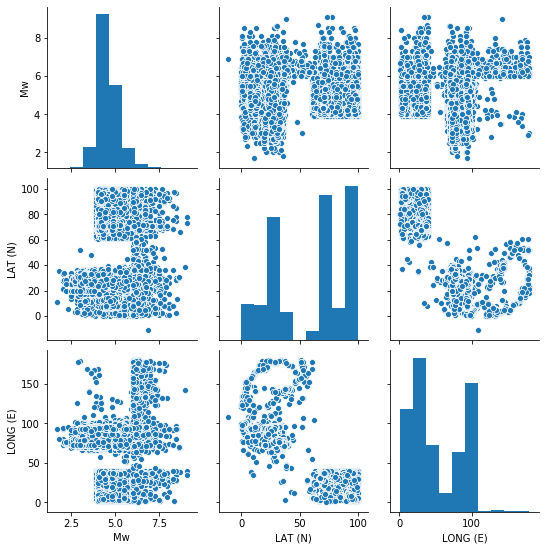

In [7]:
sns.pairplot(df, vars = ["Mw", "LAT (N)", "LONG (E)"])
plt.show()

## Data preparation for training and testing

- **Data normalization:** We normalize the latitude, longitude and the depth values so that they are expressed on a common scale without distorting differences in the ranges of values.
- Separate the training features and the target feature. Apply threshold to the target feature "Mw" to convert it into two classes of Mw < threshold as class '0' otherwise class '1'.
- **Train-test split:** Split the data into 80% train set and remaining 20% as test set.
- **Stratification:** We split data using **stratification** so that the ratio of both the class, 0 and 1, in both train and test sets is equal.

In [8]:
norm_cols = ["LAT (N)", "LONG (E)", "DEPTH (km)"]#, "DATETIME", "Mb", "Ms", "ML"]
for col in norm_cols:
    df[col]=((df[col]-df[col].min())/(df[col].max()-df[col].min()))

thresh = 4.5

df.loc[df['Mw'] <= thresh, 'Mw'] = 0
df.loc[df['Mw'] > thresh, 'Mw'] = 1

X = df[["YEAR", "MONTH", "DATE", "LAT (N)","LONG (E)", "DEPTH (km)"]]
y = df["Mw"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Number of class 0 data points: ", np.count_nonzero(y_train==0))
print("Number of class 1 data points: ", np.count_nonzero(y_train))

Number of class 0 data points:  21884
Number of class 1 data points:  18500


## Handling data imbalance

- We see that the data is highly **skewed or imbalanced** towards class 1.
- This may **cause the model to overfit** to class 1 which is represented more in dataset and become oblivious to the existence of the minority class. It might even give a good accuracy but **fail when applied on real data.**
- **Resampling:** To deal with this imbalance, we perform **over-sampling** or **upsampling** to create synthetic samples. To do this we use SMOTE or the Synthetic Minority Over-sampling Technique available in library imblearn.

In [9]:
sm = SMOTE(random_state=27, sampling_strategy=1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)
print("Training data size after over-sampling: ",X_train.shape)

Training data size after over-sampling:  (43768, 6)


## Classification using KNN

- We perform classification using KNN and test its perfomrance for varying number of neighbors (k)

In [10]:
num_neighbor = [3, 5, 7, 9, 11]
roc_auc, fpr, tpr = [], [], []

for n in num_neighbor:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    print("Classificatin reposrt for k = ", n)
    print(classification_report(y_test, y_pred))
    
    fpr_, tpr_, _ = roc_curve(y_test, y_pred)
    fpr.append(fpr_)
    tpr.append(tpr_)
    roc_auc.append(auc(fpr_, tpr_))

Classificatin reposrt for k =  3
              precision    recall  f1-score   support

         0.0       0.69      0.70      0.70      5471
         1.0       0.64      0.64      0.64      4626

    accuracy                           0.67     10097
   macro avg       0.67      0.67      0.67     10097
weighted avg       0.67      0.67      0.67     10097

Classificatin reposrt for k =  5
              precision    recall  f1-score   support

         0.0       0.70      0.69      0.69      5471
         1.0       0.64      0.64      0.64      4626

    accuracy                           0.67     10097
   macro avg       0.67      0.67      0.67     10097
weighted avg       0.67      0.67      0.67     10097

Classificatin reposrt for k =  7
              precision    recall  f1-score   support

         0.0       0.70      0.71      0.70      5471
         1.0       0.65      0.64      0.64      4626

    accuracy                           0.68     10097
   macro avg       0.67      

- **From the above classificatin report we see that the highest accuracy of 76% is obtained for k = 3**

**ROC-AUC plot**

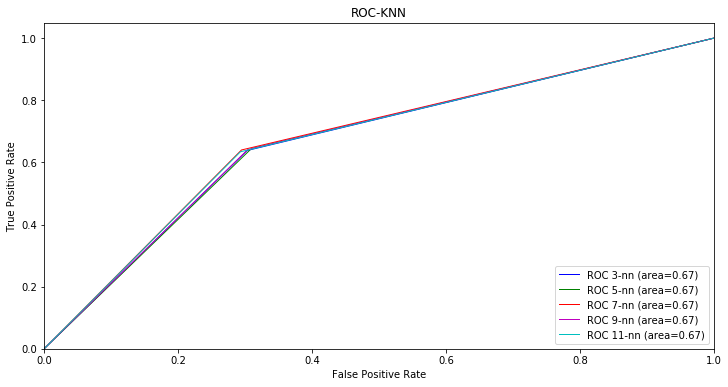

In [11]:
fig, ax1 = plt.subplots(1,1, figsize = (12,6))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC-KNN')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
color = ['b', 'g', 'r', 'm', 'c']
for i in range(len(num_neighbor)):
    ax1.plot(fpr[i], tpr[i], color=color[i],
             lw=1, label='ROC '+str(num_neighbor[i])+'-nn (area=%0.2f)' % roc_auc[i])
    ax1.legend(loc="lower right")

- **Receiver Operating charactersitics (ROC):** The ROC curve shows the trade-off between sensitivity (or TPR) and specificity (1 – FPR). Classifiers that give curves closer to the top-left corner indicate a better performance.
- From the above plot, we see that the curve for **n = 3 provides better accuracy** with higher true positive rate than the other classifiers.

## Classification using Decision Tree

- We perform classification using Decision Tree and test its perfomrance for varying number of depth using GridCV Search 



In [12]:
from sklearn.tree import DecisionTreeClassifier

depth = [7, 9, 10, 11, 15, 20,25]
roc_auc, fpr, tpr = [], [], []

for n in depth:
    tree = DecisionTreeClassifier(criterion='gini',splitter='random',max_depth=n, min_samples_leaf=10,min_samples_split=100, max_features=3)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    print("Classificatin report for depth = ", n)
    print(classification_report(y_test, y_pred))
    
    fpr_, tpr_, _ = roc_curve(y_test, y_pred)
    fpr.append(fpr_)
    tpr.append(tpr_)
    roc_auc.append(auc(fpr_, tpr_))

Classificatin report for depth =  7
              precision    recall  f1-score   support

         0.0       0.67      0.58      0.62      5471
         1.0       0.57      0.67      0.62      4626

    accuracy                           0.62     10097
   macro avg       0.62      0.62      0.62     10097
weighted avg       0.63      0.62      0.62     10097

Classificatin report for depth =  9
              precision    recall  f1-score   support

         0.0       0.69      0.69      0.69      5471
         1.0       0.63      0.63      0.63      4626

    accuracy                           0.66     10097
   macro avg       0.66      0.66      0.66     10097
weighted avg       0.66      0.66      0.66     10097

Classificatin report for depth =  10
              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67      5471
         1.0       0.61      0.60      0.61      4626

    accuracy                           0.64     10097
   macro avg       

- **From the above classificatin report we see that the highest accuracy of 81% is obtained for tree depth of 20**

**ROC-AUC plot**

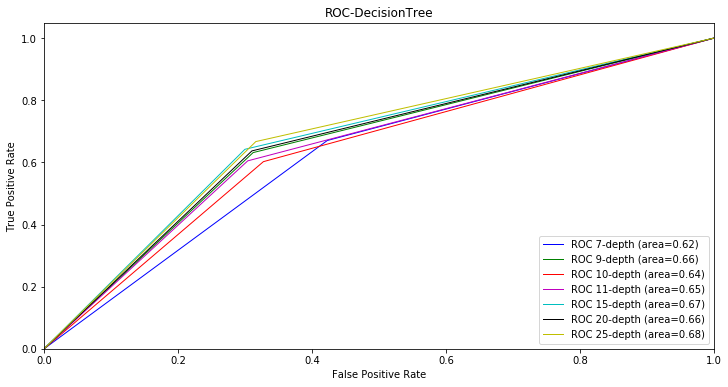

In [13]:
fig, ax1 = plt.subplots(1,1, figsize = (12,6))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC-DecisionTree')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
color = ['b', 'g', 'r', 'm', 'c','k', 'y']
for i in range(len(depth)):
    ax1.plot(fpr[i], tpr[i], color=color[i],
             lw=1, label='ROC '+str(depth[i])+'-depth (area=%0.2f)' % roc_auc[i])
    ax1.legend(loc="lower right")

### Which is the better classifier for this data amongst the two?

- **Accuracy:** Based on accuracy, decision tree is performing better with 81% accuracy than KNN which gives accuracy of 76%.
- But since the data formed is imbalanced, we should consider precsion and recall scores for comparing the two methods.
- **Precsion:** Precision is a metric that quantifies the number of correct positive predictions made. Since the data is imbalanced we consider weighted average precision. Based on that the Decision tree(Depth=20) performs slightly better with precsion of 82% than KNN(k=3) 79%.
- **Recall:** Recall is a metric that quantifies the number of correct positive predictions made out of all positive predictions. This is the most important performance metric for earthquake prediction as it tells us what percentage of positive predictions the model missed. A high recall value is important as we would not want to miss positive predictions. KNN(k=3) gives better recall of 76% than the decsion tree(Depth=20) with 71% recall.


### What could be the best possible values of the parameters for respective classifier based on the ROC curves?

- **ROC Curve:** An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds.
- **AUC (Area under the ROC Curve):** AUC provides an aggregate measure of performance across all possible classification thresholds. It measures the entire two-dimensional area underneath the entire ROC curve.
- **ROC-AUC for KNN classifier:** For all the K values tested, the classfier gives similar AUC and performs equal over all thresholds

- **ROC-AUC for Decision tree classifier:** As the depth is increased, the AUC value and hence the avergae performance of the classifier is improving till depth of 15, 20 and then it seems to decrease. Hence a tree with depth=15 peforms better overall across all thresholds.

In [25]:
df2 = df[["YEAR", "MONTH", "DATE","LAT (N)","LONG (E)","DEPTH (km)",'Mw']].copy()
df3=df2.iloc[0:10000]
print(df3.shape)
df3.head()

import pandas as pd
from sklearn import preprocessing, tree
from dtreeviz.trees import dtreeviz

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(df3.Mw)
df3['target'] = label_encoder.transform(df3.Mw)

classifier = tree.DecisionTreeClassifier(criterion='gini',splitter='random',max_depth=4, min_samples_leaf=10,min_samples_split=10, max_features=3)
classifier.fit(df3.iloc[:,:6], df3.Mw)

viz = dtreeviz(classifier,
         df3.iloc[:,:6],
         df3.target,
         target_name='Earthquake',
         feature_names=df3.columns[0:6],
         class_names=list(label_encoder.classes_)
         )
viz.save("tree.svg")
viz.view()

(10000, 7)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


###  If you have to choose only a subset of two features to predict earthquake, which ones would it be? Give Reasoning.
- **LAT (E), LONG  (N)** 
- **Reason**- If the dataset consists of N attributes then deciding which attribute to place at the root or at different levels of the tree as internal nodes is a complicated step
- For solving this attribute selection problem we use ginni index
- These criterions will calculate values for every attribute. The values are sorted, and attributes are placed in the tree by following the order
- We attached image of decision tree with report
- You can understand the Gini index as a cost function used to evaluate splits in the dataset. It is calculated by subtracting the sum of the squared probabilities of each class from one. It favors larger partitions and easy to implement
- Gini Index works with the categorical target variable “Success” or “Failure”
- Higher the value of Gini index higher the homogeneity.
- We plotted sample decision tree in above code and using that values we are  selectiong LAT and LONG as features
- We perform Hyperparameter Tuning using GridCV search

### Which is the better classifier for this data amongst the two?

- **Accuracy:** Based on accuracy, decision tree is performing better with 81% accuracy than KNN which gives accuracy of 76%.
- But since the data formed is imbalanced, we should consider precsion and recall scores for comparing the two methods.
- **Precsion:** Precision is a metric that quantifies the number of correct positive predictions made. Since the data is imbalanced we consider weighted average precision. Based on that the Decision tree(Depth=20) performs slightly better with precsion of 82% than KNN(k=3) 79%.
- **Recall:** Recall is a metric that quantifies the number of correct positive predictions made out of all positive predictions. This is the most important performance metric for earthquake prediction as it tells us what percentage of positive predictions the model missed. A high recall value is important as we would not want to miss positive predictions. KNN(k=3) gives better recall of 76% than the decsion tree(Depth=20) with 71% recall.

## Feature Engineering

1. **Modifying latitude and longitude:** These can be converted to 3D coordinates of x,y,z. This is specifically useful when using L-norm distance based KNN classification. The coordinates can be created as:

<center>$x = R * \cos(lat) * \cos(long)$</center>

<center>$y = R * \cos(lat) * \sin(long)$</center>

<center>$z = R * \sin(lat)$</center>

where R is radius of earth 


2. **Converting geolocation data into zones:** Clustering algorithm can be used like k-Nearest Neighbor, DBSCAN, and hierarchical clustering algorithm to group geo-location data using a small number of potential clusters and assign each cluster or a group a unique id. These unique id can then replace latitude and longitude column.